This notebook is for PCA operations on the original Wildfire dataset

# Import Lib

In [1]:
import dataset
from tensorflow import estimator as tf_estimator
import models.losses as losses
import tensorflow as tf
from models.metrics import *
import models.cnn_autoencoder_model as cnnmodel
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.decomposition import PCA
import xgboost as xgb

# Load Dataset

In [2]:
hparams = {
    # 数据路径
    'train_path': '../dataset/next_day_wildfire_spread_train*',
    'eval_path': '../dataset/next_day_wildfire_spread_eval*',
    'test_path': '../dataset/next_day_wildfire_spread_test*',
    
    # 特征
    'input_features': ['elevation', 'pdsi', 'NDVI', 'pr', 'sph', 'th', 'tmmn',
                  'tmmx', 'vs', 'erc', 'population', 'PrevFireMask'],
    'output_features': ['FireMask'],
    
    # 方位通道
    'azimuth_in_channel': None,
    'azimuth_out_channel': None,
    
    # 数据和模型参数
    'data_sample_size': 64,
    'sample_size': 32,
    'output_sample_size': 32,
    'batch_size': 128,
    'shuffle': False,
    'shuffle_buffer_size': 10000,
    'compression_type': None,
    'input_sequence_length': 1,
    'output_sequence_length': 1,
    'repeat': False,
    'clip_and_normalize': True,
    'clip_and_rescale': False,
    
    # 数据增强
    'random_flip': False,
    'random_rotate': False,
    'random_crop': True,
    'center_crop': False,
    
    # 其他参数
    'downsample_threshold': 0.0,
    'binarize_output': True
}

train_dataset = dataset.make_dataset(
    hparams,
    mode = tf_estimator.ModeKeys.TRAIN
)
val_dataset = dataset.make_dataset(
    hparams,
    mode = tf_estimator.ModeKeys.EVAL
)
test_dataset = dataset.make_dataset(
    hparams,
    mode = tf_estimator.ModeKeys.PREDICT
)

In [3]:
def dataset_to_numpy(dataset):
    features_list = []
    labels_list = []
    for features, label in dataset:
        features_list.append(features.numpy())  # 提取特征并转换为 NumPy 数组
        labels_list.append(label.numpy())       # 提取标签并转换为 NumPy 数组
    return np.vstack(features_list), np.concatenate(labels_list)

# 转换数据集
train_x, train_y = dataset_to_numpy(train_dataset)
val_x, val_y = dataset_to_numpy(val_dataset)
test_x, test_y = dataset_to_numpy(test_dataset)

train_y[train_y == -1] = 0
val_y[val_y == -1] = 0
test_y[test_y == -1] = 0

In [4]:
train_x.reshape(train_x.shape[0], -1).shape

(14979, 12288)

# PCA

In [5]:
# num_samples = train_x.shape[0]
# reshaped_train_x = train_x.reshape(num_samples, -1)
# 创建PCA实例
pca = PCA(n_components=12)

# 拟合数据并转换
pca.fit(train_x.reshape(train_x.shape[0], -1))

# 使用训练集的 PCA 参数转换所有数据集
transformed_train_x = pca.transform(train_x.reshape(train_x.shape[0], -1))
transformed_val_x = pca.transform(val_x.reshape(val_x.shape[0], -1))
transformed_test_x = pca.transform(test_x.reshape(test_x.shape[0], -1))

In [8]:
import numpy as np

# 假设 pca.components_ 是您的PCA组件
components = pca.components_
contribution = []
# 对每个主成分进行处理
for i, component in enumerate(components):
    # 将主成分重塑为原始图像的形状
    reshaped_component = component.reshape(32, 32, 12)

    # 计算每个通道的贡献
    channel_contributions = np.sum(np.abs(reshaped_component), axis=(0, 1))

    # 归一化贡献
    normalized_contributions = channel_contributions / np.sum(channel_contributions)

    contribution.append(normalized_contributions)

    print(f"Channel Contributions to Principal Component {i+1}: {normalized_contributions}")


Channel Contributions to Principal Component 1: [0.25412333 0.08751214 0.06998161 0.01576488 0.14204682 0.06919766
 0.0522676  0.0136095  0.02928235 0.22852659 0.03507965 0.00260791]
Channel Contributions to Principal Component 2: [0.03156701 0.0208056  0.04693165 0.00260502 0.1338581  0.06622667
 0.20981468 0.20333159 0.12191103 0.14824358 0.01039374 0.0043114 ]
Channel Contributions to Principal Component 3: [0.14679109 0.12920155 0.00729868 0.00187994 0.0273004  0.3283226
 0.07269343 0.07766458 0.13401654 0.03945439 0.03243343 0.00294346]
Channel Contributions to Principal Component 4: [0.10526601 0.19553491 0.06533226 0.00254802 0.02604872 0.2388344
 0.0273119  0.02050156 0.23382461 0.05948434 0.02435753 0.00095581]
Channel Contributions to Principal Component 5: [0.13470514 0.27740166 0.00681834 0.01837759 0.09940974 0.01024024
 0.0754289  0.05408213 0.30198416 0.00586663 0.01429411 0.00139138]
Channel Contributions to Principal Component 6: [0.07198273 0.13004114 0.17497171 0.015

In [10]:

train_y_flat = train_y.reshape(train_y.shape[0], -1)
val_y_flat = val_y.reshape(val_y.shape[0], -1)
test_y_flat = test_y.reshape(test_y.shape[0], -1)

# 假设 transformed_train_x, train_y, transformed_val_x, val_y, transformed_test_x 是你的数据集

# 创建 DMatrix
dtrain = xgb.DMatrix(transformed_train_x, label=train_y_flat)
dval = xgb.DMatrix(transformed_val_x, label=val_y_flat)
dtest = xgb.DMatrix(transformed_test_x, label=test_y_flat)

# 设置参数
params = {
    'max_depth': 3,  # 树的最大深度
    'eta': 0.1,      # 学习率
    'objective': 'binary:logistic',  # 二分类的逻辑回归问题
    'eval_metric': 'logloss'  # 评估指标
}
num_round = 100  # 训练轮数

# 训练模型
bst = xgb.train(params, dtrain, num_round, evals=[(dval, 'eval')], early_stopping_rounds=10)

# 预测
predictions = bst.predict(dtest)

# 输出预测结果
print(predictions)

[0]	eval-logloss:0.18590
[1]	eval-logloss:0.17786
[2]	eval-logloss:0.17082
[3]	eval-logloss:0.16467
[4]	eval-logloss:0.15929
[5]	eval-logloss:0.15460
[6]	eval-logloss:0.15050
[7]	eval-logloss:0.14692
[8]	eval-logloss:0.14381
[9]	eval-logloss:0.14111
[10]	eval-logloss:0.13876
[11]	eval-logloss:0.13672
[12]	eval-logloss:0.13495
[13]	eval-logloss:0.13343
[14]	eval-logloss:0.13212
[15]	eval-logloss:0.13099
[16]	eval-logloss:0.13002
[17]	eval-logloss:0.12919
[18]	eval-logloss:0.12848
[19]	eval-logloss:0.12787
[20]	eval-logloss:0.12736
[21]	eval-logloss:0.12693
[22]	eval-logloss:0.12656
[23]	eval-logloss:0.12627
[24]	eval-logloss:0.12602
[25]	eval-logloss:0.12582
[26]	eval-logloss:0.12566
[27]	eval-logloss:0.12553
[28]	eval-logloss:0.12544
[29]	eval-logloss:0.12537
[30]	eval-logloss:0.12532
[31]	eval-logloss:0.12529
[32]	eval-logloss:0.12526
[33]	eval-logloss:0.12526
[34]	eval-logloss:0.12526
[35]	eval-logloss:0.12527
[36]	eval-logloss:0.12528
[37]	eval-logloss:0.12531
[38]	eval-logloss:0.12

In [15]:
loaded_bst = xgb.Booster()
loaded_bst.load_model('saved_model/xgboost.model')
predictions = loaded_bst.predict(dtest)

In [16]:
test_y_flat = test_y.reshape(test_y.shape[0], -1)

mask = test_y_flat != -1

# 应用掩码
masked_labels = test_y_flat[mask]
masked_predictions = predictions[mask]

# 计算 AUC
auc_metric = tf.keras.metrics.AUC(curve='PR')
auc_metric.update_state(masked_labels, masked_predictions)
auc = auc_metric.result().numpy()

print("AUC with masked class: %.2f" % auc)

AUC with masked class: 0.06


# SHAP

In [17]:
import shap

# 创建一个 SHAP 解释器
explainer = shap.TreeExplainer(loaded_bst)

# 计算 SHAP 值
shap_values = explainer.shap_values(dtest)

# 可视化第一个预测的 SHAP 值
shap.initjs()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[21:10:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [18]:
TITLES = [
  'Elevation',
  'Wind direction',
  'Wind velocity',
  'Min temp',
  'Max temp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population density',
  'Energy release component',
  'Previous fire mask',
]

In [19]:
np.array(shap_values).shape
average_shap_values = np.mean(shap_values, axis=0)

[0.47682688 0.20540373 0.08129188 0.04893349 0.01736587 0.01841266
 0.0248694  0.02103801 0.01442313 0.01336184 0.02377275 0.01677488]


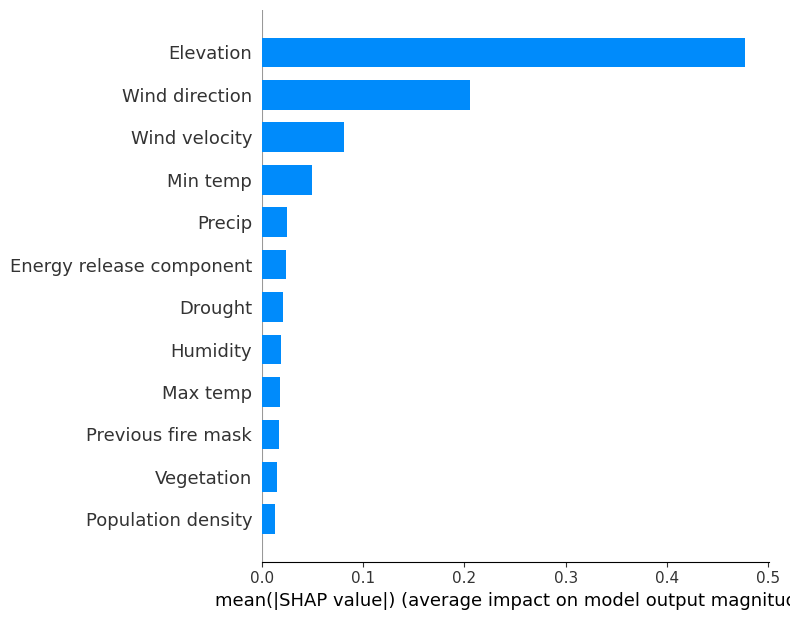

In [24]:
average_shap_values = np.mean(shap_values, axis=0)

# 使用 shap.summary_plot 展示平均 SHAP 值
shap.summary_plot(average_shap_values, feature_names=TITLES, plot_type='bar')